In [1]:
import time
import requests
from bs4 import BeautifulSoup as BS
import csv
import pandas as pd
import numpy as np
import json

In [2]:
import sqlite3
import mysql.connector
import config
from mysql.connector import errorcode
from datetime import date, datetime, timedelta

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

In [419]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password
)
cursor = cnx.cursor(buffered=True)

In [420]:
api_key = config.api_key

In [421]:
db_name = 'movie_database'

In [422]:
def create_database(cursor, database):
    try:
        cursor.execute(
           "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)
try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)
cnx.commit()

In [6]:
imdb_query = """CREATE TABLE imdb(
movie_id INT PRIMARY KEY AUTO_INCREMENT,
imdb_id TEXT NOT NULL,
name TEXT,
number_of_votes REAL,
user_rating REAL,
metascore_rating REAL,
gross TEXT
)"""

In [12]:
cursor.execute(imdb_query)
cnx.commit()

In [7]:
genre_movie = """CREATE TABLE genre_movie(
genre_id INT,
movie_id INT,
FOREIGN KEY (genre_id) REFERENCES genre(genre_id),
FOREIGN KEY (movie_id) REFERENCES imdb(movie_id))"""

In [16]:
cursor.execute(genre_movie)
cnx.commit()

In [37]:
genre_query = """CREATE TABLE genre_1(
imdb_id TEXT,
genre TEXT)"""

In [38]:
cursor.execute(genre_query)
cnx.commit()

In [9]:
stars_query = """CREATE TABLE stars(
star_id INT PRIMARY KEY AUTO_INCREMENT,
star_name TEXT)"""

In [14]:
cursor.execute(stars_query)
cnx.commit()

In [10]:
star_movie = """CREATE TABLE star_movie(
star_id INT,
movie_id INT,
FOREIGN KEY (star_id) REFERENCES stars(star_id),
FOREIGN KEY (movie_id) REFERENCES imdb(movie_id))"""

In [15]:
cursor.execute(star_movie)
cnx.commit()

In [17]:
tmdb_query = """CREATE TABLE tmdb(
tmdb_id TEXT NOT NULL,
title TEXT,
vote_count REAL,
vote_average REAL,
popularity REAL,
release_date DATETIME,
imdb_id TEXT)"""

In [18]:
cursor.execute(tmdb_query)
cnx.commit()

In [29]:
def imdb_call(start_number):
    url = f"https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&languages=en&sort=num_votes,desc&start={start_number}&explore=genres&ref_=adv_nxt"
    page = requests.get(url)
    soup = BS(page.content, 'html.parser')
    return soup

In [52]:
def create_imdb_dict(soup):
    all_blocks = soup.find_all(class_='lister-item-content')
    imdb_id = [id['href'].split('/')[2] for id in soup.select('.lister-item-header a')]
    new_list = []
    for i in all_blocks:
        new_dict={}
        new_dict['imdb_id'] = i.select('.lister-item-header a')[0]['href'].split('/')[2]
        new_dict["name"] = i.select('.lister-item-header a')[0].text
        new_dict["num_of_votes"] = i.select('.sort-num_votes-visible')[0].text.split('\n')[2].replace(',','')
        try:
            cur_gross = i.select('.sort-num_votes-visible')[0].text.split('\n')[4]
            new_dict["gross"] = cur_gross
        except:
            new_dict["gross"] = None
        new_dict["user_rating"] = i.select('.inline-block.ratings-imdb-rating')[0].text.replace('\n', '')
        try:
            cur_meta = i.select('.inline-block.ratings-metascore')[0].text.split('\n')[1].strip()
            new_dict["metascore"] = cur_meta
        except:
            new_dict["metascore"] = None
        new_dict["genre"] = i.select('.genre')[0].text.replace('\n', '').strip().replace(' ','').split(',') 
        new_dict["movie_star"] = i.find(class_='ratings-bar').nextSibling.nextSibling.nextSibling.nextSibling.text.replace(', ','').strip().split('\n')[-4:]
        new_list.append(new_dict)
    return new_list, imdb_id

In [25]:
def create_imdb_tuple(imdb_dict_list):
    tuple_list = []
    for data in imdb_dict_list:
        new_tuple = (data['imdb_id'],data['name'], data['num_of_votes'], data['user_rating'],data['metascore'],data['gross'])
        tuple_list.append(new_tuple)
    return tuple_list

In [26]:
def insert_into_imdb(tuple_list):
    insert_imdb = """INSERT INTO imdb(imdb_id,name, number_of_votes, user_rating,metascore_rating, gross)
    VALUES (%s,%s,%s,%s,%s,%s)"""
    cursor.executemany(insert_imdb,tuple_list)
    cnx.commit()

In [19]:
def tmdb_call(imdb_id, api_key):
    tmdb_url= f'https://api.themoviedb.org/3/find/{imdb_id}?api_key={api_key}&&language=en-US&external_source=imdb_id'
    response = requests.get(tmdb_url)
    rsp=response.json()
    time.sleep(3)
    return rsp

In [46]:
def create_tmdb_dictionaries(rsp, imdb_id):
    tmdb_list= []
    tmdb_dict = {}
    for data in rsp["movie_results"]:
        tmdb_dict["tmdb_id"] = data["id"]
        tmdb_dict["tmdb_title"] = data["title"]
        tmdb_dict["tmdb_vote_count"] = data["vote_count"]
        tmdb_dict["tmdb_vote_avg"] = data["vote_average"]
        tmdb_dict["tmdb_popularity"] = data['popularity']
        tmdb_dict["release_date"] = data['release_date']
        tmdb_dict["imdb_id"] = imdb_id
        tmdb_list.append(tmdb_dict)
    return tmdb_list

In [50]:
def create_tmdb_tuple(tmdb_list):
    tuple_list_tmdb = []
    for data in tmdb_list:
        new_tuple_tmdb = (data['tmdb_id'],data['tmdb_title'], data['tmdb_vote_count'], data['tmdb_vote_avg'],data['tmdb_popularity'],data['release_date'],data['imdb_id'])
        tuple_list_tmdb.append(new_tuple_tmdb)
    return tuple_list_tmdb

In [48]:
def insert_into_tmdb(tuple_list_tmdb):
    insert_tmdb = """INSERT INTO tmdb(tmdb_id, title, vote_count, vote_average,popularity, release_date, imdb_id)
    VALUES (%s,%s,%s,%s,%s,%s,%s)"""
    cursor.executemany(insert_tmdb,tuple_list_tmdb)
    cnx.commit()

In [40]:
def id_genre_list(imdb_dict):
    id_genre_list = []
    for i in imdb_dict:
        id_genre_dict = {}
        id_genre_dict[i['imdb_id']]= i['genre']
        id_genre_list.append(id_genre_dict)
    return id_genre_list

In [39]:
def genre_formatting(id_genre_list):
    formatted_genres = []
    for genre in id_genre_list:
        for key, value in genre.items():
            for genre in value:
                genre_tuple = ( key ,genre )
                formatted_genres.append(genre_tuple)
    return formatted_genres

In [44]:
def insert_into_genre(genre_formatted):
    for elem in genre_formatted:
        insert_genre = """INSERT IGNORE INTO genre_1 (imdb_id, genre) VALUES (%s,%s)"""
        cursor.execute(insert_genre,elem)
        cnx.commit()

In [65]:
def all_results(start_number, api_key):
    cur = start_number
    results = []
    while cur < 3001:
        soup = imdb_call(cur)
        dict1 = create_imdb_dict(soup)
        imdb_tuple = create_imdb_tuple(dict1[0])
        results.append(dict1[0]) #use function to parse result, put in database and then move on to next call
        insert_into_imdb(imdb_tuple)
        genre_list = id_genre_list(dict1[0])
        genre_tuples = genre_formatting(genre_list)
        insert_into_genre(genre_tuples)
        for elem in dict1[1]:
            call = tmdb_call(elem, api_key)
            dict2 = create_tmdb_dictionaries(call, elem)
            tmdb_tuple = create_tmdb_tuple(dict2)
            insert_into_tmdb(tmdb_tuple)
        time.sleep(1) #Wait a second
        cur += 50
        print(f"insterting at {cur}")
    return results

In [54]:
results = all_results(451,api_key)

insterting at 501
insterting at 551
insterting at 601
insterting at 651
insterting at 701
insterting at 751
insterting at 801
insterting at 851
insterting at 901
insterting at 951
insterting at 1001


In [59]:
results[1]

[{'imdb_id': 'tt0453467',
  'name': 'Deja Vu',
  'num_of_votes': '278901',
  'gross': '$64.04M',
  'user_rating': '7.0',
  'metascore': '59',
  'genre': ['Action', 'Crime', 'Sci-Fi'],
  'movie_star': ['Denzel Washington',
   'Paula Patton',
   'Jim Caviezel',
   'Val Kilmer']},
 {'imdb_id': 'tt0163025',
  'name': 'Jurassic Park III',
  'num_of_votes': '278383',
  'gross': '$181.17M',
  'user_rating': '5.9',
  'metascore': '42',
  'genre': ['Action', 'Adventure', 'Sci-Fi'],
  'movie_star': ['Sam Neill',
   'William H. Macy',
   'Téa Leoni',
   'Alessandro Nivola']},
 {'imdb_id': 'tt0359950',
  'name': 'The Secret Life of Walter Mitty',
  'num_of_votes': '278159',
  'gross': '$58.24M',
  'user_rating': '7.3',
  'metascore': '54',
  'genre': ['Comedy', 'Drama', 'Fantasy'],
  'movie_star': ['Ben Stiller', 'Kristen Wiig', 'Jon Daly', 'Kathryn Hahn']},
 {'imdb_id': 'tt0129387',
  'name': "There's Something About Mary",
  'num_of_votes': '277292',
  'gross': '$176.48M',
  'user_rating': '7.1'

In [62]:
results2 = all_results(1001,api_key)

insterting at 1051
insterting at 1101
insterting at 1151
insterting at 1201
insterting at 1251
insterting at 1301
insterting at 1351
insterting at 1401
insterting at 1451
insterting at 1501


In [64]:
results3 = all_results(1501,api_key)

insterting at 1551
insterting at 1601
insterting at 1651
insterting at 1701
insterting at 1751
insterting at 1801
insterting at 1851
insterting at 1901
insterting at 1951
insterting at 2001
insterting at 2051
insterting at 2101
insterting at 2151
insterting at 2201
insterting at 2251
insterting at 2301
insterting at 2351
insterting at 2401
insterting at 2451
insterting at 2501


In [66]:
results4 = all_results(2501, api_key)

insterting at 2551
insterting at 2601
insterting at 2651
insterting at 2701
insterting at 2751
insterting at 2801
insterting at 2851
insterting at 2901
insterting at 2951
insterting at 3001


In [67]:
top_10 = """SELECT name, user_rating, metascore_rating FROM imdb
ORDER BY user_rating DESC LIMIT 10"""
cursor.execute(top_10)
top_10_df = pd.DataFrame(cursor.fetchall())
top_10_df.columns = [x[0] for x in cursor.description]
top_10_df

,name,user_rating,metascore_rating
0,The Shawshank Redemption,9.3,80.0
1,The Godfather,9.2,100.0
2,The Dark Knight,9.0,84.0
3,The Godfather: Part II,9.0,90.0
4,Pulp Fiction,8.9,94.0
5,The Lord of the Rings: The Return of the King,8.9,94.0
6,Schindler's List,8.9,94.0
7,12 Angry Men,8.9,96.0
8,Inception,8.8,74.0
9,Fight Club,8.8,66.0


In [68]:
top_10_df.metascore_rating = top_10_df.metascore_rating.apply(lambda x: x/10)
top_10_df

,name,user_rating,metascore_rating
0,The Shawshank Redemption,9.3,8.0
1,The Godfather,9.2,10.0
2,The Dark Knight,9.0,8.4
3,The Godfather: Part II,9.0,9.0
4,Pulp Fiction,8.9,9.4
5,The Lord of the Rings: The Return of the King,8.9,9.4
6,Schindler's List,8.9,9.4
7,12 Angry Men,8.9,9.6
8,Inception,8.8,7.4
9,Fight Club,8.8,6.6


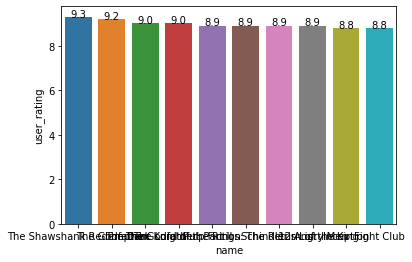

In [70]:
top_10_plot = sns.barplot(x='name', y='user_rating',data=top_10_df)
for index, row in top_10_df.iterrows():
    top_10_plot.text(row.name,row.user_rating, round(row.user_rating,2), color='black', ha="center")

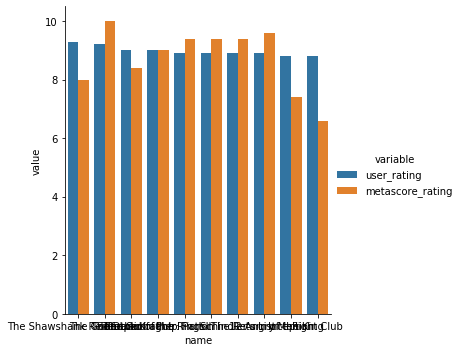

In [71]:
test_df = pd.melt(top_10_df, id_vars=['name'], value_vars=['user_rating', 'metascore_rating'])

test_top_10 = sns.catplot(x='name', y='value',hue='variable',data=test_df, kind='bar')

In [352]:
genre_rating = """SELECT genre, COUNT(genre),AVG(user_rating) AS avg_rating, AVG(metascore_rating)/10 AS avg_metascore, AVG(vote_average) as tmdb_avg_rating FROM imdb 
                  JOIN genre_1 USING(imdb_id)
                  JOIN tmdb USING(imdb_id)
                  GROUP BY genre
                  HAVING COUNT(genre)>100
                  ORDER BY avg_rating DESC
                    """
cursor.execute(genre_rating)
genre_rating_df = pd.DataFrame(cursor.fetchall())
genre_rating_df.columns = [x[0] for x in cursor.description]
genre_rating_df

,genre,COUNT(genre),avg_rating,avg_metascore,tmdb_avg_rating
0,Biography,202,7.417822,6.967662,7.234158
1,Drama,1445,7.155848,6.482913,6.996194
2,Animation,180,7.108889,6.807865,6.950000
3,Crime,590,6.933220,5.919716,6.747966
4,Thriller,575,6.814957,5.837004,6.644870
5,Mystery,310,6.804516,5.734122,6.686774
6,Romance,417,6.796403,5.839951,6.735492
7,Adventure,751,6.752330,5.853125,6.613848
8,Family,170,6.720588,6.088125,6.689412
9,Sci-Fi,327,6.714373,5.698742,6.549847


In [353]:
genre_rating_df

,genre,COUNT(genre),avg_rating,avg_metascore,tmdb_avg_rating
0,Biography,202,7.417822,6.967662,7.234158
1,Drama,1445,7.155848,6.482913,6.996194
2,Animation,180,7.108889,6.807865,6.950000
3,Crime,590,6.933220,5.919716,6.747966
4,Thriller,575,6.814957,5.837004,6.644870
5,Mystery,310,6.804516,5.734122,6.686774
6,Romance,417,6.796403,5.839951,6.735492
7,Adventure,751,6.752330,5.853125,6.613848
8,Family,170,6.720588,6.088125,6.689412
9,Sci-Fi,327,6.714373,5.698742,6.549847


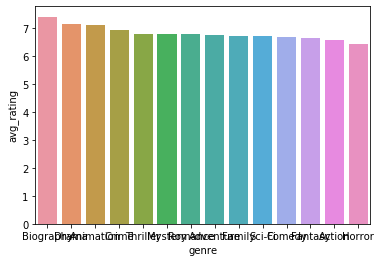

In [82]:
genre_rating_plot = sns.barplot(x='genre', y='avg_rating',data=genre_rating_df)

In [354]:
test_genre_df = pd.melt(genre_rating_df, id_vars=['genre'], value_vars=['avg_rating', 'avg_metascore','tmdb_avg_rating'])

In [355]:
test_genre_df

,genre,variable,value
0,Biography,avg_rating,7.417822
1,Drama,avg_rating,7.155848
2,Animation,avg_rating,7.108889
3,Crime,avg_rating,6.933220
4,Thriller,avg_rating,6.814957
5,Mystery,avg_rating,6.804516
6,Romance,avg_rating,6.796403
7,Adventure,avg_rating,6.752330
8,Family,avg_rating,6.720588
9,Sci-Fi,avg_rating,6.714373


Text(27.175755208333335, 0.5, 'Average rating')

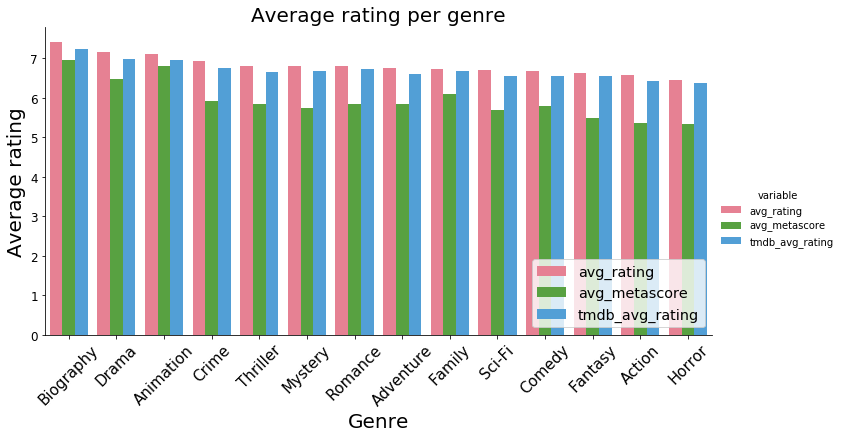

In [410]:
# plt.figure(figsize= (16,8))
test_genre_plot = sns.catplot(x='genre', y='value',hue='variable',data=test_genre_df, kind='bar', aspect = 16/8, palette = "husl")
test_genre_plot.set(xlabel = "Genre", ylabel ="Average rating")
loc, labels = plt.xticks()
loc, labels2 = plt.yticks()
test_genre_plot.set_xticklabels(labels,rotation = 45, fontsize = 15);
test_genre_plot.set_yticklabels(labels2, fontsize = 12);
leg_label = ("User", "Critic", "TMDB")
plt.legend(fontsize='x-large', title_fontsize='40', loc = 4)
plt.title("Average rating per genre", fontsize=20)
plt.xlabel("Genre", fontsize = 20)
plt.ylabel("Average rating", fontsize = 20)

In [341]:
genre_gross = """SELECT genre, SUBSTRING(gross,2,LENGTH(gross)-2) AS gross FROM imdb
JOIN genre_1 USING(imdb_id) ORDER BY gross DESC;
"""
cursor.execute(genre_gross)
genre_gross_df = pd.DataFrame(cursor.fetchall())
genre_gross_df.columns = [x[0] for x in cursor.description]

In [342]:
genre_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7879 entries, 0 to 7878
Data columns (total 2 columns):
genre    7879 non-null object
gross    7606 non-null object
dtypes: object(2)
memory usage: 123.2+ KB


In [343]:
genre_gross_df.dropna(inplace = True)

In [344]:
genre_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7606 entries, 0 to 7605
Data columns (total 2 columns):
genre    7606 non-null object
gross    7606 non-null object
dtypes: object(2)
memory usage: 178.3+ KB


In [345]:
genre_gross_df.gross = genre_gross_df.gross.apply(lambda x: float(x))

In [216]:
genre_gross_df.groupby('genre').count()

,gross
genre,
Action,902
Adventure,738
Animation,177
Biography,198
Comedy,1017
Crime,554
Drama,1376
Family,166
Fantasy,295


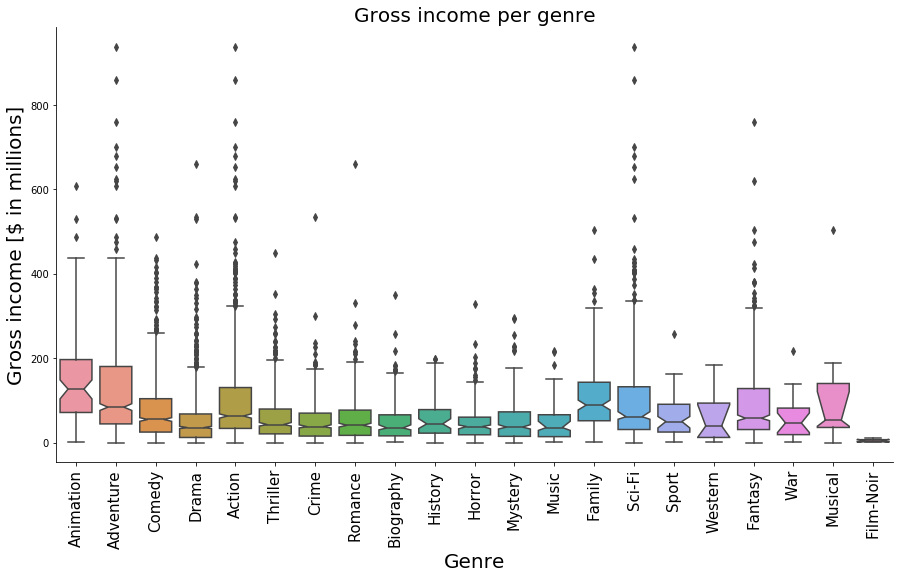

In [409]:
plt.figure(figsize = (15,8))
genre_gross_plot = sns.boxplot(x='genre', y='gross',data=genre_gross_df, notch=True, bootstrap=10000,whis = 2)
genre_gross_plot.set_xlabel("Genre", fontsize = 20)
genre_gross_plot.set_ylabel("Gross income [$ in millions]", fontsize = 20)
genre_gross_plot.set_title("Gross income per genre", fontsize = 20)
loc, labels = plt.xticks()
genre_gross_plot.set_xticklabels(labels,rotation = 90, fontsize = 15);
# loc, labels2 = plt.yticks()
# genre_gross_plot.set_yticklabels(labels2, fontsize = 12);
sns.despine()

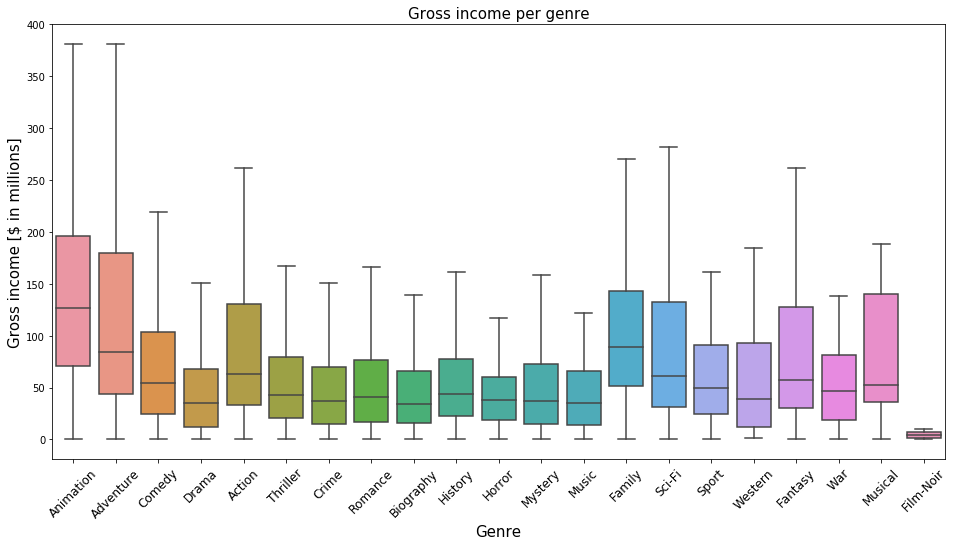

In [218]:
plt.figure(figsize=(16,8))
genre_gross_plot2 = sns.boxplot(x='genre', y='gross',data=genre_gross_df, showfliers=False)
genre_gross_plot2.set_xlabel("Genre", fontsize = 15)
genre_gross_plot2.set_ylabel("Gross income [$ in millions]", fontsize = 15)
genre_gross_plot2.set_title("Gross income per genre", fontsize = 15)
loc, labels = plt.xticks()
genre_gross_plot2.set_xticklabels(labels,rotation = 45, fontsize = 12);

In [111]:
genre_num_vote = '''SELECT genre, number_of_votes FROM imdb
JOIN genre_1 USING(imdb_id)'''
cursor.execute(genre_num_vote)
genre_num_vote_df = pd.DataFrame(cursor.fetchall())
genre_num_vote_df.columns = [x[0] for x in cursor.description]
genre_num_vote_df

,genre,number_of_votes
0,Drama,2135120.0
1,Action,2099693.0
2,Crime,2099693.0
3,Drama,2099693.0
4,Action,1872564.0
5,Adventure,1872564.0
6,Sci-Fi,1872564.0
7,Drama,1706903.0
8,Crime,1675698.0
9,Drama,1675698.0


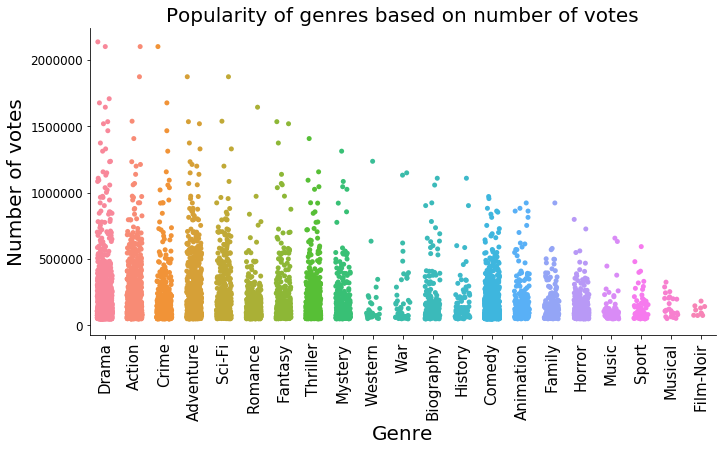

In [407]:
genre_num_vote_plot = sns.catplot(x='genre',y='number_of_votes',data=genre_num_vote_df,jitter='0.25', aspect = 16/8)
# test_genre_plot.set(xlabel = "Genre", ylabel ="Number of votes")
loc, labels = plt.xticks()
loc, labels2 = plt.yticks()
genre_num_vote_plot.set_xticklabels(labels,rotation = 90, fontsize = 15);
genre_num_vote_plot.set_yticklabels(labels2, fontsize = 12);
# leg_label = ("User", "Critic", "TMDB")
# plt.legend(fontsize='x-large', title_fontsize='40', loc = 4)
plt.title("Popularity of genres based on number of votes", fontsize=20)
plt.xlabel("Genre", fontsize = 20)
plt.ylabel("Number of votes", fontsize = 20);

In [256]:
release_date_num_of_vote = """SELECT MONTH(release_date) AS release_month,COUNT(imdb_id) AS number_of_movies, sum(number_of_votes) AS total_num_votes, MIN(release_date), MAX(release_date)
FROM imdb JOIN tmdb USING(imdb_id)
GROUP BY release_month"""
cursor.execute(release_date_num_of_vote)
release_date_num_of_vote_df = pd.DataFrame(cursor.fetchall())
release_date_num_of_vote_df.columns = [x[0] for x in cursor.description]
release_date_num_of_vote_df

,release_month,number_of_movies,total_num_votes,MIN(release_date),MAX(release_date)
0,1,141,16559961.0,1940-01-18,2019-01-31
1,2,192,31823328.0,1921-02-06,2018-02-28
2,3,231,40140717.0,1940-03-15,2019-03-23
3,4,182,31916798.0,1930-04-29,2019-04-24
4,5,237,54334862.0,1954-05-29,2019-05-29
5,6,310,60794828.0,1925-06-25,2019-06-28
6,7,265,54035772.0,1951-07-03,2019-07-25
7,8,241,35805451.0,1939-08-15,2019-08-01
8,9,314,54105529.0,1944-09-23,2019-09-04
9,10,273,49636477.0,1939-10-19,2018-10-24


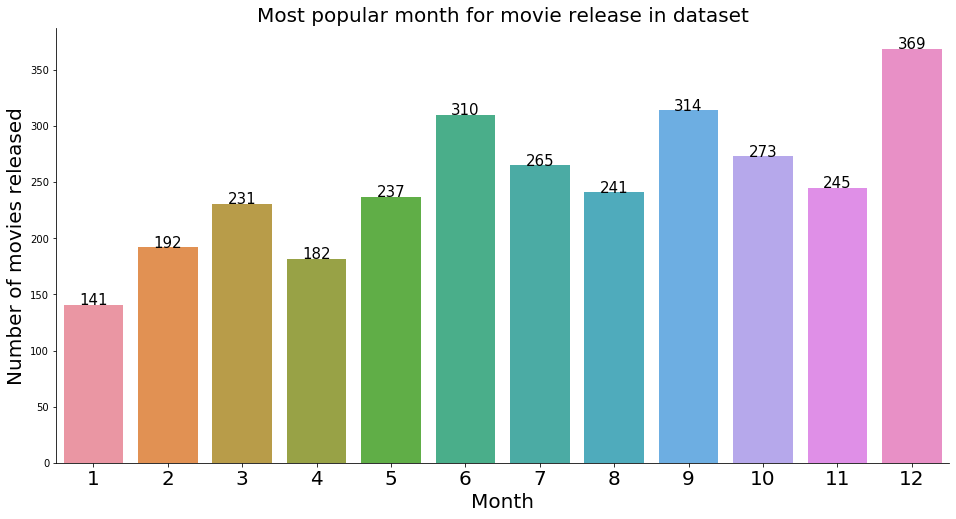

In [402]:
plt.figure(figsize=(16,8))
release_date_num_of_vote_plot = sns.barplot(x='release_month', y = 'number_of_movies', data = release_date_num_of_vote_df)
loc, labels = plt.xticks()
# loc, labels2 = plt.yticks()
release_date_num_of_vote_plot.set_xticklabels(labels, fontsize = 20);
# release_date_num_of_vote_plot.set_yticklabels(labels2, fontsize = 12);
# leg_label = ("User", "Critic", "TMDB")
# plt.legend(fontsize='x-large', title_fontsize='40', loc = 4)
plt.title("Most popular month for movie release in dataset", fontsize=20)
plt.xlabel("Month", fontsize = 20)
plt.ylabel("Number of movies released", fontsize = 20);

for index, row in release_date_num_of_vote_df.iterrows():
    release_date_num_of_vote_plot.text(row.name,row.number_of_movies, int(row.number_of_movies), color='black', ha="center", fontsize = 15)
    sns.despine()

In [286]:
release_date_avg_rating = """SELECT MONTH(release_date) AS release_month, COUNT(imdb_id), AVG(user_rating) AS user_rating
FROM imdb JOIN tmdb USING(imdb_id)
GROUP BY release_month
"""
cursor.execute(release_date_avg_rating)
release_date_avg_rating_df = pd.DataFrame(cursor.fetchall())
release_date_avg_rating_df.columns = [x[0] for x in cursor.description]

In [287]:
release_date_avg_rating_df

,release_month,COUNT(imdb_id),user_rating
0,1,141,6.585106
1,2,192,6.711458
2,3,231,6.717749
3,4,182,6.784066
4,5,237,6.816034
5,6,310,6.732258
6,7,265,6.733208
7,8,241,6.755602
8,9,314,7.019427
9,10,273,7.010989


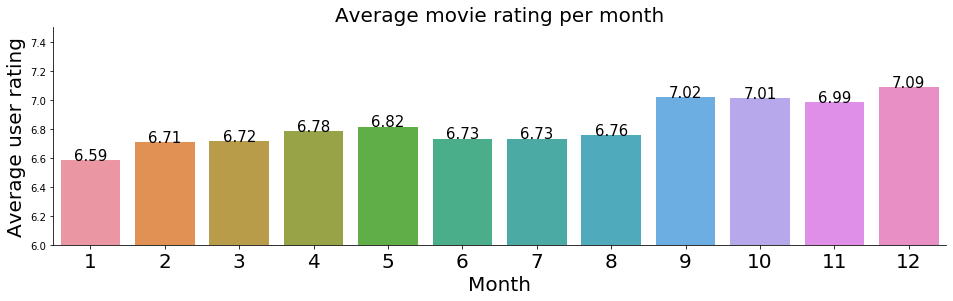

In [417]:
plt.figure(figsize=(16,4))
release_date_rating_plot = sns.barplot(x='release_month', y = 'user_rating', data = release_date_avg_rating_df)

loc, labels = plt.xticks()
# loc, labels2 = plt.yticks()
release_date_rating_plot.set_xticklabels(labels, fontsize = 20);
# release_date_num_of_vote_plot.set_yticklabels(labels2, fontsize = 12);
# leg_label = ("User", "Critic", "TMDB")
# plt.legend(fontsize='x-large', title_fontsize='40', loc = 4)
plt.title("Average movie rating per month", fontsize=20)
plt.xlabel("Month", fontsize = 20)
plt.ylabel("Average user rating", fontsize = 20);
plt.ylim(6,7.5)
for index, row in release_date_avg_rating_df.iterrows():
    release_date_rating_plot.text(row.name,row.user_rating, round(row.user_rating,2), color='black', ha="center", fontsize = 15)
sns.despine() 

In [137]:
popularity_genre = """SELECT name, genre, PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY popularity) AS median FROM imdb JOIN genre_1 USING(imdb_id) JOIN tmdb USING(imdb_id) ORDER BY popularity DESC"""

In [138]:
cursor.execute(popularity_genre)
popularity_genre_df = pd.DataFrame(cursor.fetchall())
popularity_genre_df.columns = [x[0] for x in cursor.description]
popularity_genre_df

ProgrammingError: 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'GROUP (ORDER BY popularity) AS median FROM imdb JOIN genre_1 USING(imdb_id) JOIN' at line 1

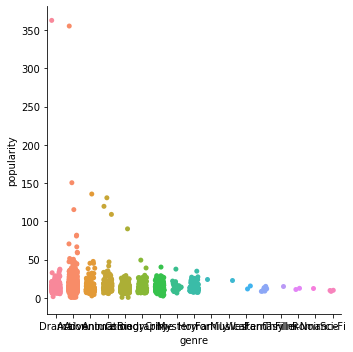

In [198]:
popularity_genre_plot = sns.catplot(x='genre',y='popularity',data=popularity_genre_df,jitter='0.25')

In [335]:
genre_gross_df= genre_gross_df

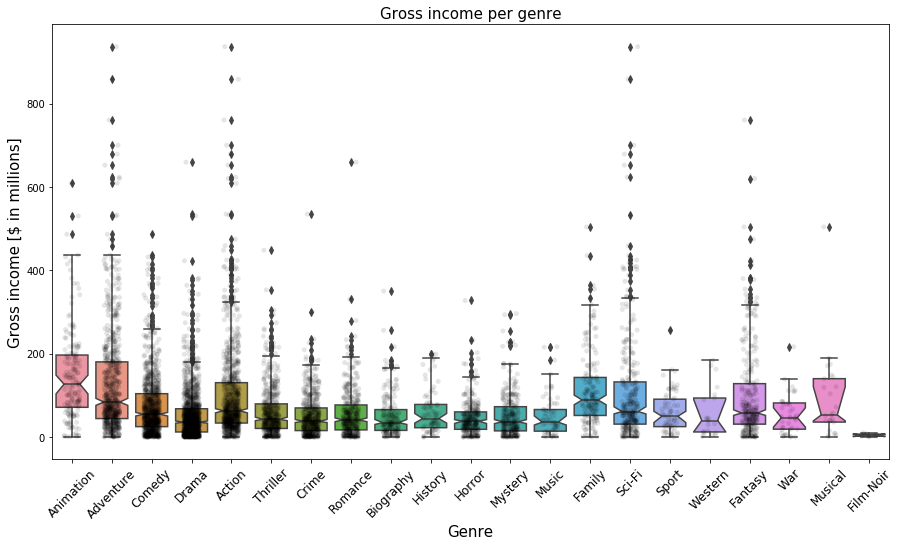

In [346]:
plt.figure(figsize = (15,8))
genre_gross_plot = sns.boxplot(x='genre', y='gross',data=genre_gross_df, notch=True, bootstrap=10000, whis=2)
scatter_on_top = sns.stripplot(x='genre', y='gross', data=genre_gross_df, alpha=0.1,jitter=0.2,color='k');
genre_gross_plot.set_xlabel("Genre", fontsize = 15)
genre_gross_plot.set_ylabel("Gross income [$ in millions]", fontsize = 15)
genre_gross_plot.set_title("Gross income per genre", fontsize = 15)
loc, labels = plt.xticks()
genre_gross_plot.set_xticklabels(labels,rotation = 45, fontsize = 12);
# loc, labels2 = plt.yticks()
# genre_gross_plot.set_yticklabels(labels2, fontsize = 12);

In [288]:
release_year_avg_rating = """SELECT YEAR(release_date) AS release_year, COUNT(imdb_id) as count
FROM imdb JOIN tmdb USING(imdb_id)
GROUP BY release_year
"""
cursor.execute(release_year_avg_rating)
release_year_avg_rating_df = pd.DataFrame(cursor.fetchall())
release_year_avg_rating_df.columns = [x[0] for x in cursor.description]

In [289]:
release_year_avg_rating_df

,release_year,count
0,1921,1
1,1925,1
2,1926,1
3,1930,1
4,1931,2
5,1933,2
6,1934,1
7,1936,1
8,1937,1
9,1938,1


In [302]:
decade_dict = {}
for index,year in enumerate(release_year_avg_rating_df["release_year"]):
    decade = int(year)//10
    if decade in decade_dict:
        decade_dict[decade] += release_year_avg_rating_df["count"][index]
    else:
        decade_dict[decade] = release_year_avg_rating_df["count"][index]
    decade_dict["total"] = sum(release_year_avg_rating_df["count"])
decade_dict

{192: 3,
 'total': 3000,
 193: 12,
 194: 23,
 195: 40,
 196: 53,
 197: 76,
 198: 212,
 199: 476,
 200: 1031,
 201: 1074}

In [ ]:
total_dict = {'total': }

In [323]:
table_year = pd.DataFrame.from_dict(decade_dict,orient='index')
table_year.rename(index={192:'1920s',193:'1930s',194:'1940s',195:'1950s', 196:'1960s', 197:'1970s', 198:'1980s',199:'1990s',200:'2000s',201:'2010s'}, inplace=True)
row_names = ['1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s']
table_year.reset_index().sort_values(by=['index']).rename(columns ={'index' : "Decades", 0:"Count"})

,Decades,Count
0,1920s,3
2,1930s,12
3,1940s,23
4,1950s,40
5,1960s,53
6,1970s,76
7,1980s,212
8,1990s,476
9,2000s,1031
10,2010s,1074


In [294]:
# !pip install plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
hist_decades = decade_dict

init_notebook_mode(connected=True)
iplot([{'type':'bar','x' : ['1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s'],'y': list(hist_decades.values())}])



In [ ]:
genre_rating_scat = """SELECT genre,user_rating, (metascore_rating)/10 AS metascore, vote_average as tmdb_rating FROM imdb 
                  JOIN genre_1 USING(imdb_id)
                  JOIN tmdb USING(imdb_id)
                  ORDER BY user_rating DESC
                    """
cursor.execute(genre_rating_scat)
genre_rating_scat_df = pd.DataFrame(cursor.fetchall())
genre_rating_scat_df.columns = [x[0] for x in cursor.description]
genre_rating_scat_df

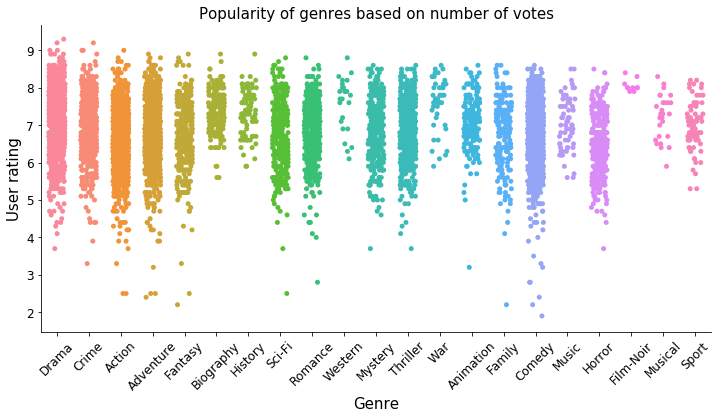

In [360]:
genre_rating_scat_plot = sns.catplot(x='genre',y='user_rating',data=genre_rating_scat_df,jitter='0.25', aspect = 16/8)
# test_genre_plot.set(xlabel = "Genre", ylabel ="Number of votes")
loc, labels = plt.xticks()
loc, labels2 = plt.yticks()
genre_rating_scat_plot.set_xticklabels(labels,rotation = 45, fontsize = 12);
genre_rating_scat_plot.set_yticklabels(labels2, fontsize = 12);
# leg_label = ("User", "Critic", "TMDB")
# plt.legend(fontsize='x-large', title_fontsize='40', loc = 4)
plt.title("Popularity of genres based on number of votes", fontsize=15)
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("User rating", fontsize = 15);

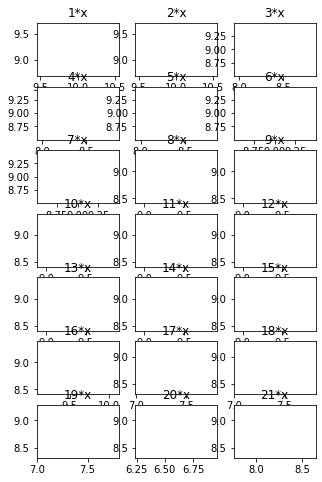

In [375]:
fig, axes = plt.subplots(7,3, figsize=(5, 8))

for n in range(1,22):
    row = (n-1)//3
    col = n%3-1
    ax = axes[row][col]
    x = genre_rating_scat_df['metascore'][n]
    y = genre_rating_scat_df['user_rating'][n]
    ax.plot(x,y)
    ax.set_title('{}*x'.format(n))

In [376]:
genre_rating_scat_df_melt = pd.melt(genre_rating_scat_df, id_vars = ['genre'], value_vars = ['user_rating','metascore'])
genre_rating_scat_df_melt

,genre,variable,value
0,Drama,user_rating,9.3
1,Crime,user_rating,9.2
2,Drama,user_rating,9.2
3,Action,user_rating,9.0
4,Crime,user_rating,9.0
5,Drama,user_rating,9.0
6,Crime,user_rating,9.0
7,Drama,user_rating,9.0
8,Crime,user_rating,8.9
9,Drama,user_rating,8.9


In [359]:
genre_rating_scat = """SELECT genre,user_rating, (metascore_rating)/10 AS metascore, vote_average as tmdb_rating FROM imdb 
                  JOIN genre_1 USING(imdb_id)
                  JOIN tmdb USING(imdb_id)
                  ORDER BY user_rating DESC
                    """
cursor.execute(genre_rating_scat)
genre_rating_scat_df = pd.DataFrame(cursor.fetchall())
genre_rating_scat_df.columns = [x[0] for x in cursor.description]
genre_rating_scat_df

,genre,user_rating,metascore,tmdb_rating
0,Drama,9.3,8.0,8.7
1,Crime,9.2,10.0,8.6
2,Drama,9.2,10.0,8.6
3,Action,9.0,8.4,8.4
4,Crime,9.0,8.4,8.4
5,Drama,9.0,8.4,8.4
6,Crime,9.0,9.0,8.5
7,Drama,9.0,9.0,8.5
8,Crime,8.9,9.4,8.4
9,Drama,8.9,9.4,8.4


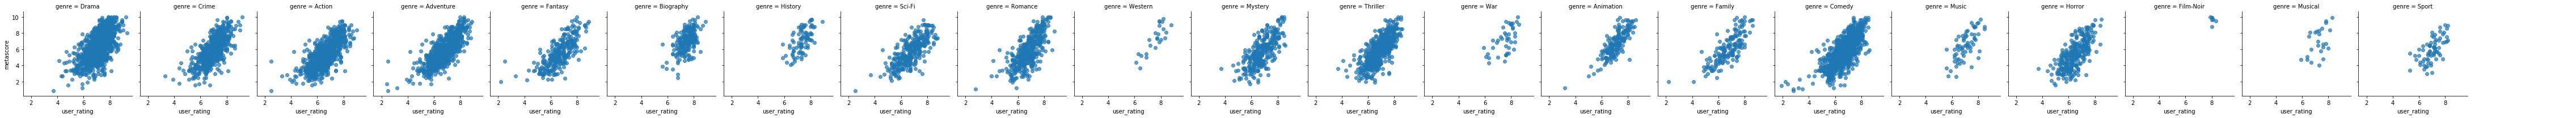

In [392]:
g = sns.FacetGrid(genre_rating_scat_df, col="genre", margin_titles=True,palette='Set1')
g.map(plt.scatter, "user_rating",'metascore', alpha=.7)
g.add_legend();

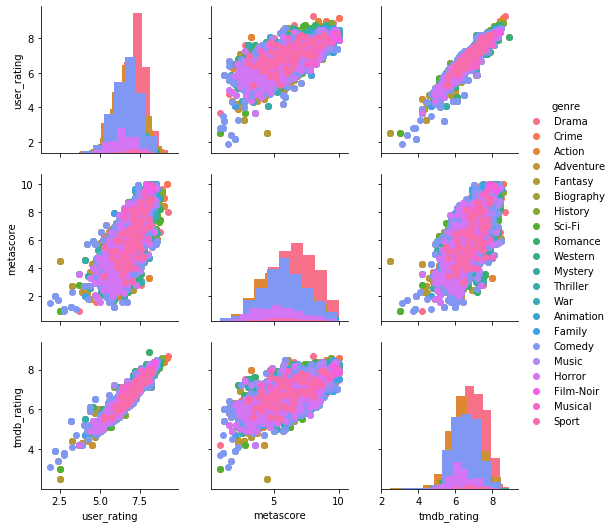

In [386]:
g = sns.PairGrid(genre_rating_scat_df, hue="genre")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

In [398]:
table_year.reset_index().sort_values(by=['index']).transpose().rename(index ={'index' : "Decades", 0:"Count"})

,0,2,3,4,5,6,7,8,9,10,1
Decades,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,total
Count,3,12,23,40,53,76,212,476,1031,1074,3000


In [432]:
genre_gross = """SELECT MONTH(release_date) AS month, AVG(SUBSTRING(gross,2,LENGTH(gross)-2)) as gross FROM imdb 
                  JOIN genre_1 USING(imdb_id)
                  JOIN tmdb USING(imdb_id)
                  GROUP BY month
                    """
cursor.execute(genre_gross)
genre_gross_df = pd.DataFrame(cursor.fetchall())
genre_gross_df.columns = [x[0] for x in cursor.description]
genre_gross_df

,month,gross
0,1,41.668017
1,2,61.018525
2,3,72.926242
3,4,79.018556
4,5,110.255237
5,6,112.324551
6,7,87.587254
7,8,57.294219
8,9,38.713337
9,10,58.300608


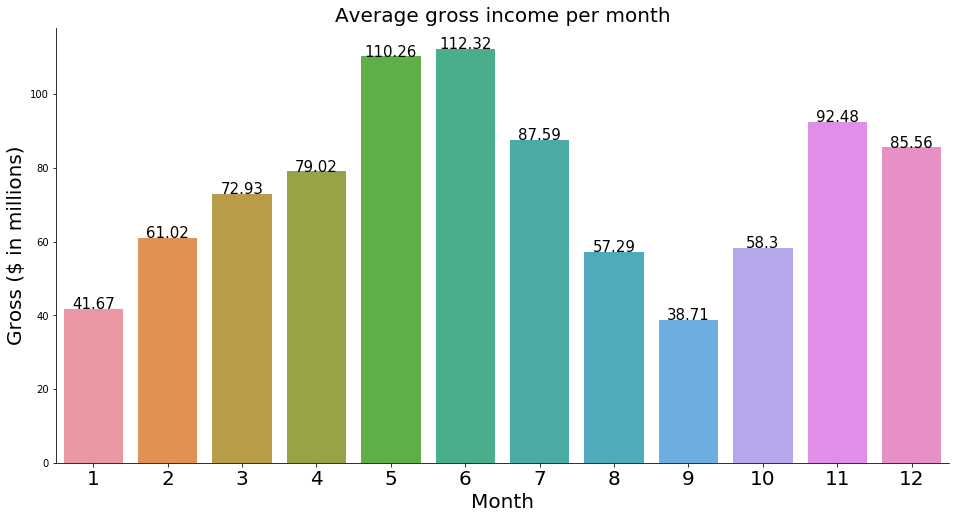

In [436]:
plt.figure(figsize=(16,8))
genre_gross_plot = sns.barplot(x='month', y = 'gross', data = genre_gross_df)
loc, labels = plt.xticks()
# loc, labels2 = plt.yticks()
genre_gross_plot.set_xticklabels(labels, fontsize = 20);
# release_date_num_of_vote_plot.set_yticklabels(labels2, fontsize = 12);
# leg_label = ("User", "Critic", "TMDB")
# plt.legend(fontsize='x-large', title_fontsize='40', loc = 4)
plt.title("Average gross income per month", fontsize=20)
plt.xlabel("Month", fontsize = 20)
plt.ylabel("Gross ($ in millions)", fontsize = 20);

for index, row in genre_gross_df.iterrows():
    genre_gross_plot.text(row.name,row.gross, round(row.gross,2), color='black', ha="center", fontsize = 15)
    sns.despine()

In [471]:
release_year_genre = """SELECT genre, FLOOR(YEAR(release_date)/10) AS release_year, AVG(number_of_votes) AS num_votes
FROM imdb JOIN tmdb USING(imdb_id) JOIN genre_1 USING (imdb_id) GROUP BY release_year, genre
"""
cursor.execute(release_year_genre)
release_year_genre_df = pd.DataFrame(cursor.fetchall())
release_year_genre_df.columns = [x[0] for x in cursor.description]

In [442]:
decade_dict = {}
for index,year in enumerate(release_year_genre_df["release_year"]):
    decade = int(year)//10
    if decade in decade_dict:
        decade_dict[decade] += release_year_genre_df["count"][index]
    else:
        decade_dict[decade] = release_year_genre_df["count"][index]
decade_dict

{192: 9,
 193: 33,
 194: 61,
 195: 103,
 196: 133,
 197: 181,
 198: 532,
 199: 1256,
 200: 2694,
 201: 2877}

In [467]:
release_year_genre_df

,genre,release_year,user_rating
0,Action,192,8.100000
1,Adventure,192,8.150000
2,Comedy,192,8.200000
3,Drama,192,8.250000
4,Family,192,8.300000
5,Adventure,193,7.950000
6,Animation,193,7.600000
7,Comedy,193,8.150000
8,Drama,193,8.166667
9,Family,193,8.000000


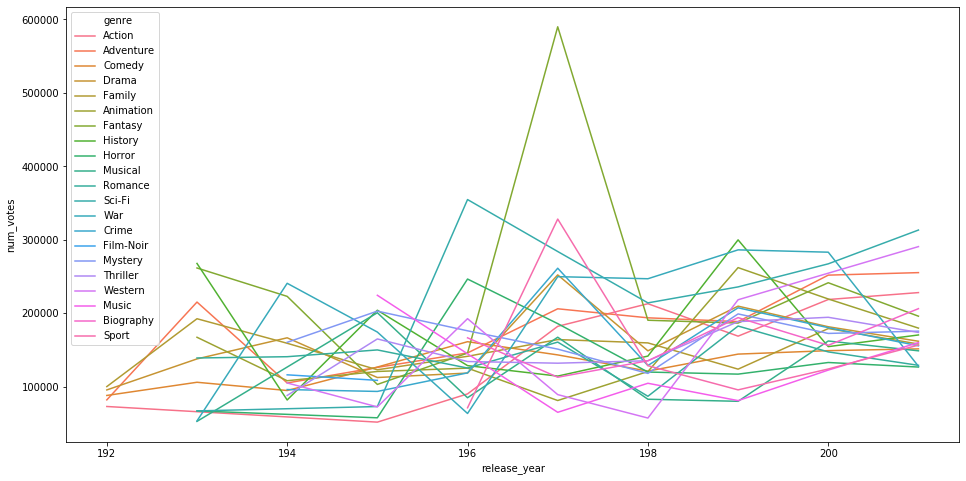

In [472]:
plt.figure(figsize = (16,8))

release_year_genre_df_plot= sns.lineplot(x='release_year', y = 'num_votes',hue="genre", data =release_year_genre_df)


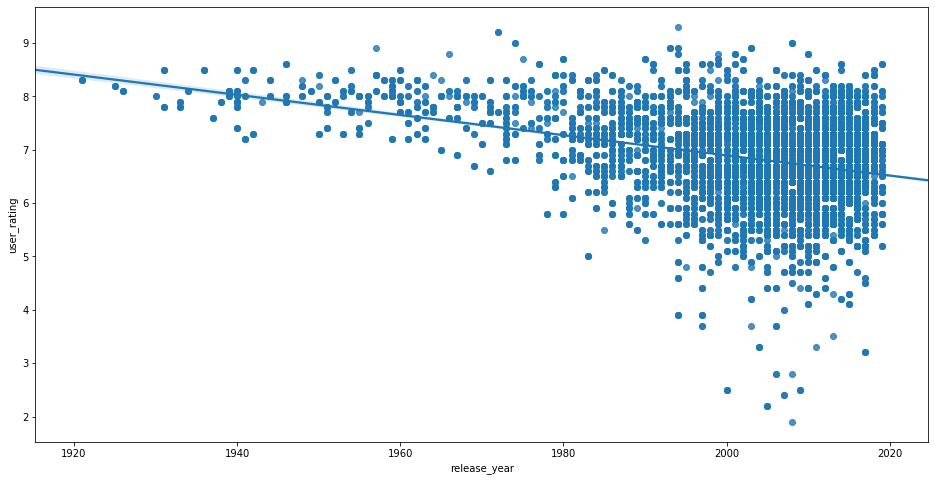

In [456]:
plt.figure(figsize = (16,8))
x = release_year_genre_df['release_year']
plotplot = sns.regplot(x="release_year", y="user_rating", data=release_year_genre_df)

In [ ]:
# !pip install plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
hist_decades = decade_dict

init_notebook_mode(connected=True)
iplot([{'type':'bar','x' : ['1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s'],'y': list(hist_decades.values())}])


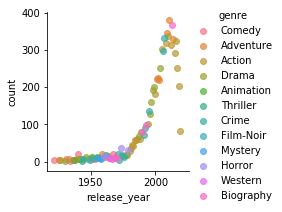

In [447]:
g = sns.FacetGrid(release_year_genre_df,  hue="genre")
g.map(plt.scatter, "release_year", "count", alpha=.7)
g.add_legend();